## example: 
### importing .ipf iMOD flowpath files



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyhydro


#### Step 1. Start importing metadata of wells
metadata should contain at least two columns with X- and Y-coordinates, called 'X' and 'Y'.

In [2]:
print('Four wells of Cothen')
data_wells = pd.read_excel(r"C:\Users\mulderma\Documents\Python\pyhydro\0.4\examples\data\wells_Cothen.xlsx")
print('Note the columns X and Y with coordinates')
data_wells.head()

Four wells of Cothen
Note the columns X and Y with coordinates


,Name,Locatie,X,Y,BK_Filter_mNAP,OK_Filter_mNAP
0,COPP002,CTH,149443,444403,-55.67,-73.67
1,COPP003,CTH,149507,444479,-61.74,-86.89
2,COPP004,CTH,149561,444555,-59.46,-84.67
3,COPP005,CTH,149418,444318,-65.20,-102.45


#### Step 2. Import headsfile of your modelsimulation
In this example we use the steady state heads of our regional model.

Modelextent: [xmin, ymin, xmax, ymax] = [139500.0, 455000.0, 159500.0, 435000.0]


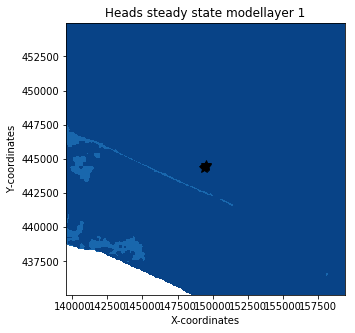

In [3]:
path_heads = r'C:\Users\mulderma\Documents\Python\pyhydro\0.4\examples\data\head_steady-state_l1.idf'
idf_heads, extent_heads, heads_xs, heads_ys = pyhydro.idf.import_idf(path_heads)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5));
ax.contourf(heads_xs, heads_ys, idf_heads[0, 0, :, :], cmap='Blues');
ax.plot(data_wells.loc[:, 'X'], data_wells.loc[:, 'Y'], '*', color='black', markersize=10);
ax.set_title('Heads steady state modellayer 1');
ax.set_xlabel('X-coordinates');
ax.set_ylabel('Y-coordinates');
print('Modelextent: [xmin, ymin, xmax, ymax] =',extent_heads)
plt.show(fig)


#### Step 3. Import .ipf iMOD flowpath data
Forward flowpath calculations have been calculated using iMOD. Starting points started above the confined layer, which confines the pump filters. 

In [4]:
path_ipf = r'C:\Users\mulderma\Documents\Python\pyhydro\0.4\examples\data\run3_Cothen_100m_Huidig_imodpath.ipf'

# import ipf_data and extract x- and y-coordinates
ipf_data, ipf_xs, ipf_ys = pyhydro.ipf.import_ipf(path_ipf, report=False)
#print('X-coordinates of .ipf flowpath results:',ipf_xs)
#print('Y-coordinates of .ipf flowpath results:',ipf_ys)
print('.ipf flowpath data:')
ipf_data.head()


.ipf flowpath data:


,SP_XCRD.,SP_YCRD.,SP_ZCRD.,SP_ILAY,SP_IROW,SP_ICOL,EP_XCRD.,EP_YCRD.,EP_ZCRD.,EP_ILAY,EP_IROW,EP_ICOL,TIME(YEARS),MAXLAYER,DISTANCE,IDENT.NO.,CAPTURED_BY,imodpath_col,imodpath_row
0,145050.0,448950.0,-52.495,6.0,61.0,56.0,144501.2,448813.0,-90.61119,7.0,62.0,51.0,99.93155,7.0,566.8810,1.0,7.0,0.0,0.0
1,145150.0,448950.0,-52.340,6.0,61.0,57.0,144659.0,448827.9,-88.24079,7.0,62.0,52.0,99.93155,7.0,507.2694,2.0,7.0,1.0,0.0
2,145250.0,448950.0,-52.201,6.0,61.0,58.0,144844.3,448847.2,-83.72286,7.0,62.0,54.0,99.93155,7.0,419.7468,3.0,7.0,2.0,0.0
3,145350.0,448950.0,-51.801,6.0,61.0,59.0,145182.7,448906.1,-71.65192,7.0,61.0,57.0,99.93155,7.0,174.0839,4.0,7.0,3.0,0.0
4,145450.0,448950.0,-19.188,5.0,61.0,60.0,144911.6,448804.5,-87.83669,7.0,62.0,55.0,99.93155,7.0,561.9560,5.0,7.0,4.0,0.0


#### Step 4. Extract well cells in modelsimulation
Calculates the cell numbers (rows and columns) of the wells in the modelsimulation

In [5]:
dx = (heads_xs[1:-1] - heads_xs[0:-2]).mean()
print('model dx =',dx)
data_wells, well_bundle = pyhydro.ipf.get_well_cells(data_wells, model_xs=heads_xs, model_ys=heads_ys, model_dx=dx, report=False)
print('Note how the IROW and ICOL numbers are added to the well data')
print('These IROW and ICOL numbers refer to the well location in the modelsimulation')
data_wells.head()


model dx = 100.0
Note how the IROW and ICOL numbers are added to the well data
These IROW and ICOL numbers refer to the well location in the modelsimulation


,Name,Locatie,X,Y,BK_Filter_mNAP,OK_Filter_mNAP,ICOL,IROW
0,COPP002,CTH,149443,444403,-55.67,-73.67,100.0,106.0
1,COPP003,CTH,149507,444479,-61.74,-86.89,101.0,106.0
2,COPP004,CTH,149561,444555,-59.46,-84.67,101.0,105.0
3,COPP005,CTH,149418,444318,-65.20,-102.45,100.0,107.0


#### Step 5. Extract all .ipf flowpaths that end up in your well cells. 
So, we're interested in all flowpath that end up in our pumps, so we can extract a capture zone of the wellfield and save it as raster data. We calculate the capture zone of each well and save it to rasters with origins and traveltimes. 

In [6]:
ipf_origin, ipf_traveltimes, data_ipf_well = pyhydro.ipf.flowpath_origin(data_wells, ipf_data, ipf_xs, ipf_ys, report=False)
print('Note how the ipf flowpath data is linked to the well it is captured by: columns Well_nr and Well_code')
data_ipf_well.head()

Note how the ipf flowpath data is linked to the well it is captured by: columns Well_nr and Well_code


,SP_XCRD.,SP_YCRD.,SP_ZCRD.,SP_ILAY,SP_IROW,SP_ICOL,EP_XCRD.,EP_YCRD.,EP_ZCRD.,EP_ILAY,...,EP_ICOL,TIME(YEARS),MAXLAYER,DISTANCE,IDENT.NO.,CAPTURED_BY,imodpath_col,imodpath_row,Well_nr,Well_code
2748,149850.0,446250.0,-13.051,5.0,88.0,104.0,149400.0,444421.4,-88.18723,7.0,...,100.0,93.08960,7.0,1884.694,2749.0,5.0,48.0,27.0,0,COPP002
2750,150050.0,446250.0,-13.130,5.0,88.0,106.0,149400.0,444460.5,-88.99018,7.0,...,100.0,88.16352,7.0,1905.442,2751.0,5.0,50.0,27.0,0,COPP002
2751,150150.0,446250.0,-13.168,5.0,88.0,107.0,149400.0,444478.6,-88.12412,7.0,...,100.0,84.32168,7.0,1925.100,2752.0,5.0,51.0,27.0,0,COPP002
2752,150250.0,446250.0,-13.203,5.0,88.0,108.0,149400.0,444494.6,-88.29386,7.0,...,100.0,78.88768,7.0,1951.790,2753.0,5.0,52.0,27.0,0,COPP002
2753,150350.0,446250.0,-13.238,5.0,88.0,109.0,149410.9,444500.0,-88.81053,7.0,...,100.0,76.14520,7.0,1987.513,2754.0,5.0,53.0,27.0,0,COPP002


Plot the capture zones of each well and the traveltimes


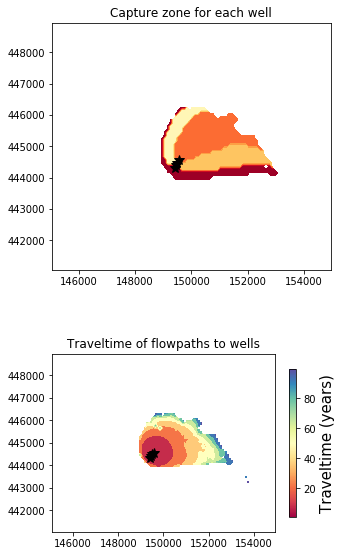

In [7]:
print('Plot the capture zones of each well and the traveltimes')
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5,10));
ax[0].contourf(ipf_xs, ipf_ys, ipf_origin, cmap='YlOrRd')
ax[0].plot(data_wells.loc[:, 'X'], data_wells.loc[:, 'Y'], '*', color='black', markersize=10);
ax[0].set_title('Capture zone for each well')
ax[1].contourf(ipf_xs, ipf_ys, ipf_traveltimes, cmap='Spectral')
ax[1].plot(data_wells.loc[:, 'X'], data_wells.loc[:, 'Y'], '*', color='black', markersize=10);
ax[1].set_title('Traveltime of flowpaths to wells')

image_extent=(ipf_xs.min(), ipf_xs.max(), ipf_ys.min(), ipf_ys.max())
pos = ax[1].imshow(ipf_traveltimes, extent=image_extent, cmap='Spectral')
cbar = fig.colorbar(pos, ax=ax[1], shrink=0.6)
cbar.set_label('Traveltime (years)', fontsize=15)


#### Step 6. Finally, plot the heads of the modelsimulation and the traveltimes from the flowpath simulation

Plot the heads of the modelsimulation and the capture zone with traveltimes of the flowpath simulation


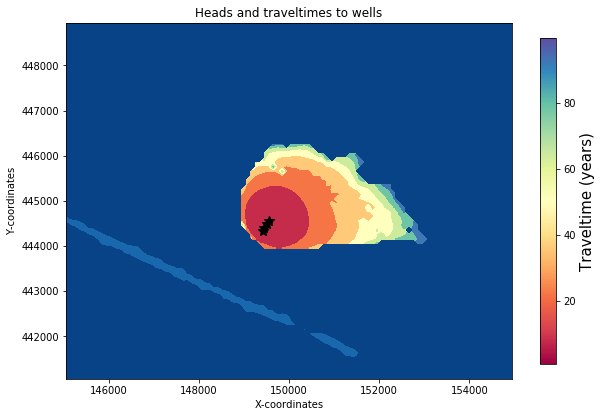

In [8]:
print('Plot the heads of the modelsimulation and the capture zone with traveltimes of the flowpath simulation')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10));
ax.contourf(heads_xs, heads_ys, idf_heads[0, 0, :, :], cmap='Blues');
ax.plot(data_wells.loc[:, 'X'], data_wells.loc[:, 'Y'], '*', color='black', markersize=10);
ax.set_title('Heads and traveltimes to wells');
ax.set_xlabel('X-coordinates');
ax.set_ylabel('Y-coordinates');
ax.contourf(ipf_xs, ipf_ys, ipf_traveltimes, cmap='Spectral')
ax.plot(data_wells.loc[:, 'X'], data_wells.loc[:, 'Y'], '*', color='black', markersize=10);
image_extent=(ipf_xs.min(), ipf_xs.max(), ipf_ys.min(), ipf_ys.max())
pos = ax.imshow(ipf_traveltimes, extent=image_extent, cmap='Spectral')
cbar = fig.colorbar(pos, ax=ax, shrink=0.6)
cbar.set_label('Traveltime (years)', fontsize=15)
plt.show(fig)

#### Step 7. Optionally, save to GeoTiff file

In [9]:
pyhydro.write.save_ipf_as_tif(ipf_traveltimes, ipf_xs, ipf_ys, file_path=r"C:\Users\mulderma\Documents\Python\pyhydro\0.4\examples", file_name='example_traveltime')

GeoTiff saved in C:\Users\mulderma\Documents\Python\pyhydro\0.4\examples
